In [102]:
import pandas as pd
import sqlite3
from sqlite3 import Error
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose

import statsmodels.api as sm

In [60]:
pd.options.display.max_columns = 150

In [2]:
def create_connection(db_file):
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        print(sqlite3.version)
    except Error as e:
        print(e)
    return conn

database = r"pythonsqlite.db"
conn = create_connection(database)

2.6.0


In [18]:
query = '''
SELECT 
    PRICE_DATE, 
    h.FIGI,
    CLOSE_PRICE,
    OPEN_PRICE,
    HIGH_PRICE,
    LOW_PRICE,
    CURRENCY,
    NAME,
    TICKER,
    ISIN
FROM stocks_daily h
LEFT JOIN 
    stocks i ON i.FIGI = h.FIGI
'''
stocks_daily_df_1 = pd.read_sql(sql=query, con=conn)

In [19]:
query = ''' SELECT * FROM stocks_yahoo '''
stocks_yahoo_df_1 = pd.read_sql(sql=query, con=conn)

In [71]:
stocks_daily_df_1['PRICE_DATE'] = pd.to_datetime(stocks_daily_df_1['PRICE_DATE'])
stocks_daily_df_1.loc[:, 'WEEKDAY'] = stocks_daily_df_1.loc[:, 'PRICE_DATE'].dt.weekday
stocks_daily_df_1.loc[:, 'MONTH'] = stocks_daily_df_1.loc[:, 'PRICE_DATE'].dt.month

In [130]:
stocks_daily_df_1['PRICE_DATE'] = stocks_daily_df_1['PRICE_DATE'].dt.tz_localize(None)

In [72]:
stocks_yahoo_df_1['SYMBOL'] = stocks_yahoo_df_1['SYMBOL'].str.replace('\.ME', '')
stocks_yahoo_df_1['SYMBOL'] = stocks_yahoo_df_1['SYMBOL'].str.replace('\.DE', '@DE')

<ipython-input-72-84bf872b9c9a>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  stocks_yahoo_df_1['SYMBOL'] = stocks_yahoo_df_1['SYMBOL'].str.replace('\.ME', '')
<ipython-input-72-84bf872b9c9a>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  stocks_yahoo_df_1['SYMBOL'] = stocks_yahoo_df_1['SYMBOL'].str.replace('\.DE', '@DE')


In [73]:
stocks_daily_df_2 = stocks_daily_df_1.merge(
    stocks_yahoo_df_1, how="inner", left_on="TICKER", right_on="SYMBOL"
)

stocks_daily_df_2 = stocks_daily_df_2[
    ~(
        (stocks_daily_df_2["MARKET"] == "us_market")
        & (stocks_daily_df_2["CURRENCY"] == "RUB")
    )
].reset_index(drop = True)



In [93]:
stocks_daily_df_2.sample(4)

,PRICE_DATE,FIGI,CLOSE_PRICE,OPEN_PRICE,HIGH_PRICE,LOW_PRICE,CURRENCY,NAME,TICKER,ISIN,WEEKDAY,MONTH,SYMBOL,SECTOR,INDUSTRY,MARKET,COUNTRY,LONG_BUSINESS_SUMMARY,CITY,FULL_TIME_EMPLOYEES,TRAILING_ANNUAL_DIVIDEND_YIELD,PAYOUT_RATIO,BETA,PRICE_HINT,FORWARD_PE,ENTERPRISE_TO_EBITDA,FORWARD_EPS,BOOK_VALUE,NET_INCOME_TO_COMMON,ENTERPRISE_TO_REVENUE,PROFIT_MARGINS,PRICE_TO_BOOK
324290,2021-02-08 07:00:00+00:00,BBG0064N2T78,27.96,28.18,28.18,27.64,USD,"Virtu Financial, Inc.",VIRT,US9282541013,0,2,VIRT,Financial Services,Capital Markets,us_market,United States,"Virtu Financial, Inc., financial services comp...",New York,976.0,0.032664,0.1829,-0.284782,2.0,10.462366,NaN,2.79,16.746,649124992.0,0.442,0.22485,1.743103
182468,2020-08-12 07:00:00+00:00,BBG000DM2BF3,46.30,45.26,46.62,45.26,USD,Sleep Number Corp,SNBR,US83125X1037,2,8,SNBR,Consumer Cyclical,"Furnishings, Fixtures & Appliances",us_market,United States,"Sleep Number Corporation, together with its su...",Minneapolis,5000.0,NaN,0.0000,1.967914,2.0,14.461212,12.732,7.09,-13.598,166683008.0,1.757,0.08538,NaN
295581,2020-11-03 07:00:00+00:00,BBG003338H34,134.65,142.88,146.50,133.33,USD,Zscaler Inc,ZS,US98980G1022,1,11,ZS,Technology,Software—Infrastructure,us_market,United States,"Zscaler, Inc. operates as a cloud security com...",San Jose,2020.0,NaN,0.0000,0.797297,2.0,356.065550,-167.931,0.61,3.700,-191432992.0,43.563,-0.35713,58.702700
19251,2020-12-24 07:00:00+00:00,BBG000BCLYL9,85.88,86.05,86.15,85.71,USD,MSC Industrial Direct Co Inc,MSM,US5535301064,3,12,MSM,Industrials,Industrial Distribution,us_market,United States,"MSC Industrial Direct Co., Inc., together with...",Melville,6200.0,0.034169,0.8982,1.030978,2.0,16.692015,13.662,5.26,19.887,186762000.0,1.873,0.05969,4.414945


Выберем несколько финансовых инструментов и займемся их визуализацией

Сдвиги праздничных дней вещь аномальная, поэтому данные по бумагам за этот день исключены из расчетов

In [75]:
stocks_daily_df_3 = stocks_daily_df_2[stocks_daily_df_2["WEEKDAY"] != 5].reset_index(
    drop=True
)


In [80]:
choosen_tickers = ["OZON", "SBER", "YNDX"]
prices_columns = ["CLOSE_PRICE", "OPEN_PRICE", "HIGH_PRICE", "LOW_PRICE"]
colors_1 = ["royalblue", "darkgreen", "red"]
colors_2 = ["dodgerblue", "limegreen", "indianred"]
df_1 = stocks_daily_df_3[stocks_daily_df_3["TICKER"].isin(choosen_tickers)].reset_index(
    drop=True
)


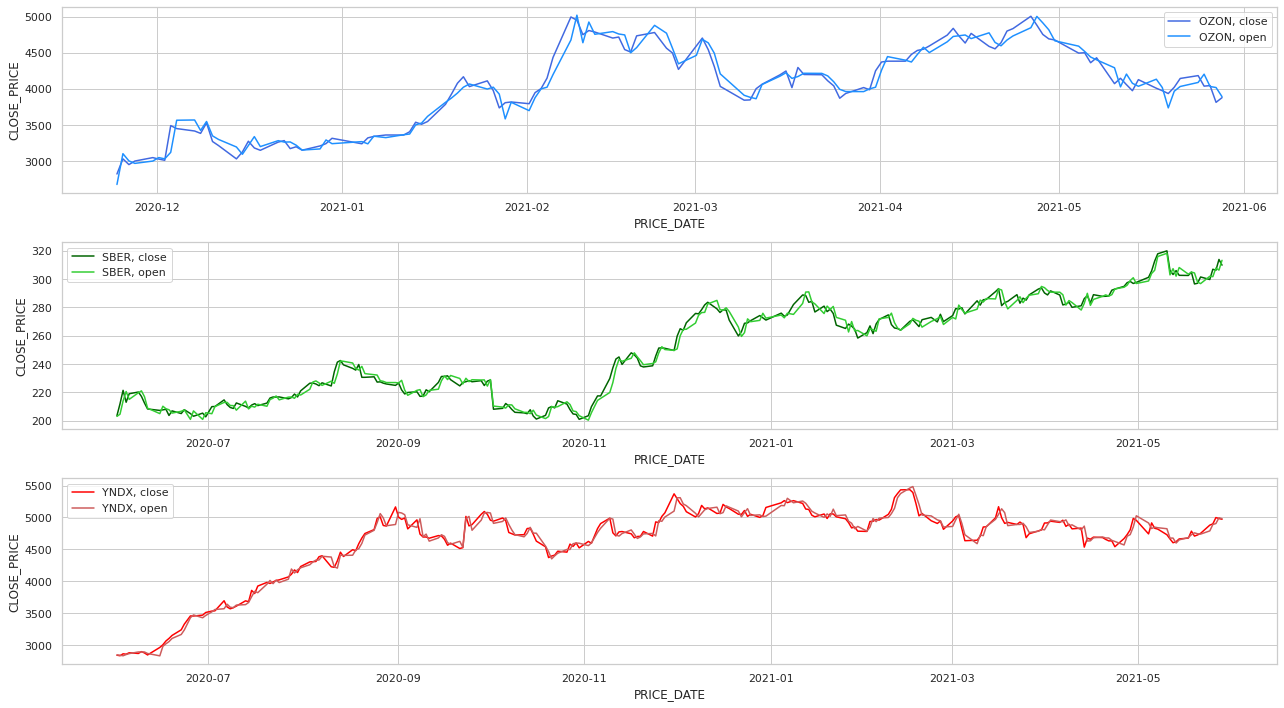

In [81]:
with sns.plotting_context("notebook"), sns.axes_style("whitegrid"):
    fig, axes = plt.subplots(3, 1, figsize=(18, 10))
    for i, ticker in enumerate(choosen_tickers):
        sns.lineplot(
            ax=axes[i],
            data=df_1[df_1["TICKER"] == ticker],
            x="PRICE_DATE",
            y="CLOSE_PRICE",
            label=ticker+', close',
            color=colors_1[i],
        )
        sns.lineplot(
            ax=axes[i],
            data=df_1[df_1["TICKER"] == ticker],
            x="PRICE_DATE",
            y="OPEN_PRICE",
            label=ticker+', open',
            color=colors_2[i],
        )
    plt.tight_layout()


In [10]:
def f_1(x):
    result = pd.Series(np.array(x.iloc[1:])/np.array(x.iloc[:-1]))
    return pd.concat([pd.Series([None]), result])

In [82]:
for field in prices_columns:
    df_1["CHANGE_" + field] = (
        df_1[field] / df_1.groupby("TICKER")["CLOSE_PRICE"].shift()
    )
    stocks_daily_df_3["CHANGE_" + field] = (
        stocks_daily_df_3[field]
        / stocks_daily_df_3.groupby("TICKER")["CLOSE_PRICE"].shift()
    )


In [84]:
df_1.groupby(["TICKER", "WEEKDAY"])[
    ["CHANGE_CLOSE_PRICE", "CHANGE_OPEN_PRICE", "CHANGE_HIGH_PRICE", "CHANGE_LOW_PRICE"]
].agg(["median", "count"])


CHANGE_CLOSE_PRICE       CHANGE_OPEN_PRICE        \
                           median count            median count   
TICKER WEEKDAY                                                    
OZON   0                 1.009670    24          1.002831    24   
       1                 1.002974    25          1.002341    25   
       2                 1.000910    27          1.003691    27   
       3                 0.992413    25          1.003592    25   
       4                 1.006456    26          1.005867    26   
SBER   0                 1.005477    49          1.002838    49   
       1                 1.003960    51          1.003841    51   
       2                 1.001059    49          1.001307    49   
       3                 0.999451    50          1.001532    50   
       4                 0.999931    50          1.000467    50   
YNDX   0                 1.008812    49          1.004588    49   
       1                 1.001106    51          1.000359    51   
       2                 1.001036    49          1.001539    49   
       3                 1.000183    50          1.000223    50   
       4                 1.001740    50          1.001732    50   

               CHANGE_HIGH_PRICE       CHANGE_LOW_PRICE        
                          median count           median count  
TICKER WEEKDAY                                                 
OZON   0                1.034703    24         0.988455    24  
       1                1.025875    25         0.974923    25  
       2                1.026786    27         0.975177    27  
       3                1.028687    25         0.972005    25  
       4                1.033433    26         0.979625    26  
SBER   0                1.014841    49         0.993533    49  
       1                1.013200    51         0.993426    51  
       2                1.011520    49         0.992663    49  
       3                1.010919    50         0.988699    50  
       4                1.006898    50         0.989826    50  
YNDX   0                1.015768    49         0.991506    49  
       1                1.013935    51         0.986300    51  
       2                1.014717    49         0.987612    49  
       3                1.012744    50         0.986807    50  
       4                1.011179    50         0.989598    50

In [87]:
stocks_daily_df_3[stocks_daily_df_3["PRICE_DATE"] > "20210301"].groupby(
    ["SECTOR", "WEEKDAY"]
)[
    ["CHANGE_CLOSE_PRICE", "CHANGE_OPEN_PRICE", "CHANGE_HIGH_PRICE", "CHANGE_LOW_PRICE"]
].agg(
    ["median"]
)


CHANGE_CLOSE_PRICE CHANGE_OPEN_PRICE  \
                                           median            median   
SECTOR                 WEEKDAY                                        
Basic Materials        0                 1.003199          1.002065   
                       1                 0.996648          1.000793   
                       2                 1.001548          1.000910   
                       3                 1.002245          1.001402   
                       4                 1.004321          1.001646   
Communication Services 0                 1.000720          1.002124   
                       1                 0.997467          1.000926   
                       2                 0.998138          1.000779   
                       3                 1.003457          1.002349   
                       4                 1.001451          1.001369   
Consumer Cyclical      0                 1.002910          1.001429   
                       1                 0.994653          1.000393   
                       2                 0.999265          1.000756   
                       3                 1.003002          1.001794   
                       4                 1.007235          1.001847   
Consumer Defensive     0                 1.002946          1.001541   
                       1                 0.996593          1.001073   
                       2                 0.998846          1.000857   
                       3                 1.002485          1.001493   
                       4                 1.003558          1.001554   
Energy                 0                 1.000000          1.002979   
                       1                 0.990976          1.001193   
                       2                 1.007571          1.001826   
                       3                 0.998620          1.001655   
                       4                 1.004444          1.002286   
Financial Services     0                 1.001730          1.000604   
                       1                 0.993447          1.000120   
                       2                 1.003132          1.001003   
                       3                 1.005268          1.000873   
                       4                 1.007804          1.002302   
Healthcare             0                 0.999768          1.001043   
                       1                 0.996796          1.000535   
                       2                 0.999191          1.000371   
                       3                 1.003164          1.001137   
                       4                 1.003956          1.001321   
Industrials            0                 1.002327          1.001287   
                       1                 0.993983          1.000000   
                       2                 1.000399          1.000669   
                       3                 1.004334          1.001604   
                       4                 1.006722          1.001695   
Real Estate            0                 1.003322          1.000621   
                       1                 0.999666          1.000553   
                       2                 0.997705          1.000196   
                       3                 1.004450          1.001098   
                       4                 1.005722          1.002041   
Technology             0                 1.001030          1.001256   
                       1                 0.995679          1.000389   
                       2                 0.997646          1.000906   
                       3                 1.005274          1.002482   
                       4                 1.005083          1.001660   
Utilities              0                 1.001935          1.001178   
                       1                 0.998662          1.000469   
                       2                 0.999198          1.000148   
                       3                 1.000309      

In [92]:
stocks_daily_df_3[stocks_daily_df_3["PRICE_DATE"] > "20210301"].groupby(
    ["SECTOR", "WEEKDAY"]
)[
    ["CHANGE_CLOSE_PRICE", "CHANGE_OPEN_PRICE", "CHANGE_HIGH_PRICE", "CHANGE_LOW_PRICE"]
].agg(
    ["median", 'count']
)


CHANGE_CLOSE_PRICE       CHANGE_OPEN_PRICE  \
                                           median count            median   
SECTOR                 WEEKDAY                                              
Basic Materials        0                 1.003199  1109          1.002065   
                       1                 0.996648  1179          1.000793   
                       2                 1.001548  1178          1.000910   
                       3                 1.002245  1178          1.001402   
                       4                 1.004321  1117          1.001646   
Communication Services 0                 1.000720  1158          1.002124   
                       1                 0.997467  1182          1.000926   
                       2                 0.998138  1182          1.000779   
                       3                 1.003457  1182          1.002349   
                       4                 1.001451  1101          1.001369   
Consumer Cyclical      0                 1.002910  2755          1.001429   
                       1                 0.994653  2794          1.000393   
                       2                 0.999265  2794          1.000756   
                       3                 1.003002  2795          1.001794   
                       4                 1.007235  2587          1.001847   
Consumer Defensive     0                 1.002946  1213          1.001541   
                       1                 0.996593  1237          1.001073   
                       2                 0.998846  1237          1.000857   
                       3                 1.002485  1238          1.001493   
                       4                 1.003558  1154          1.001554   
Energy                 0                 1.000000   828          1.002979   
                       1                 0.990976   858          1.001193   
                       2                 1.007571   858          1.001826   
                       3                 0.998620   858          1.001655   
                       4                 1.004444   807          1.002286   
Financial Services     0                 1.001730  1909          1.000604   
                       1                 0.993447  1937          1.000120   
                       2                 1.003132  1937          1.001003   
                       3                 1.005268  1937          1.000873   
                       4                 1.007804  1797          1.002302   
Healthcare             0                 0.999768  3094          1.001043   
                       1                 0.996796  3119          1.000535   
                       2                 0.999191  3119          1.000371   
                       3                 1.003164  3120          1.001137   
                       4                 1.003956  2884          1.001321   
Industrials            0                 1.002327  2889          1.001287   
                       1                 0.993983  2938          1.000000   
                       2                 1.000399  2938          1.000669   
                       3                 1.004334  2939          1.001604   
                       4                 1.006722  2730          1.001695   
Real Estate            0                 1.003322   790          1.000621   
                       1                 0.999666   806          1.000553   
                       2                 0.997705   806          1.000196   
                       3                 1.004450   806          1.001098   
                       4                 1.005722   749          1.002041   
Technology             0                 1.001030  3108          1.001256   
                       1                 0.995679  3114          1.000389   
                       2                 0.997646  3113          1.000906   
                       3                 1.005274  3115          1.002482   
                       4   

In [99]:
val_counts_1 = stocks_daily_df_3['TICKER'].value_counts()
stocks_daily_df_4 = stocks_daily_df_3[stocks_daily_df_3['TICKER'].isin(val_counts_1[val_counts_1>100].index)].reset_index()

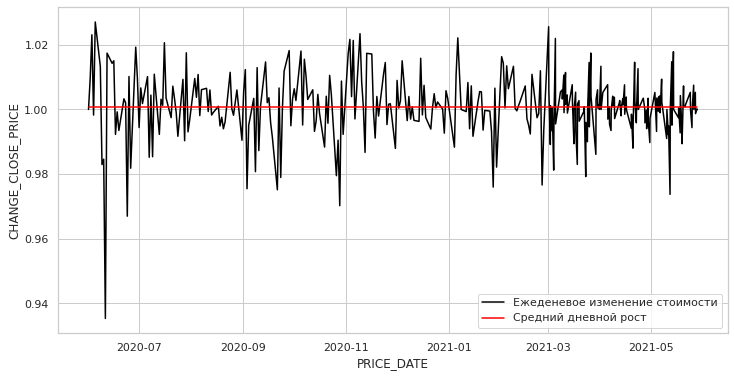

In [125]:
with sns.plotting_context("notebook"), sns.axes_style("whitegrid"):
    fig = plt.figure(figsize=(12, 6))
    sns.lineplot(
        data=stocks_daily_df_4.groupby("PRICE_DATE")["CHANGE_CLOSE_PRICE"]
        .median()
        .reset_index(),
        x="PRICE_DATE",
        y="CHANGE_CLOSE_PRICE",
        label="Ежеденевое изменение стоимости",
        color="k",
    )
    sns.lineplot(
        x=stocks_daily_df_4.groupby("PRICE_DATE")["CHANGE_CLOSE_PRICE"]
        .mean().index,
        y=stocks_daily_df_4.groupby("PRICE_DATE")["CHANGE_CLOSE_PRICE"]
        .median().mean(),
        label="Средний дневной рост",
        color="r",
    )


<ipython-input-110-6ae5bfc05826>:1: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  result = seasonal_decompose(df_1[df_1['TICKER']=='OZON']['CLOSE_PRICE'], model='additive', freq = 5)


<Figure size 432x288 with 0 Axes>

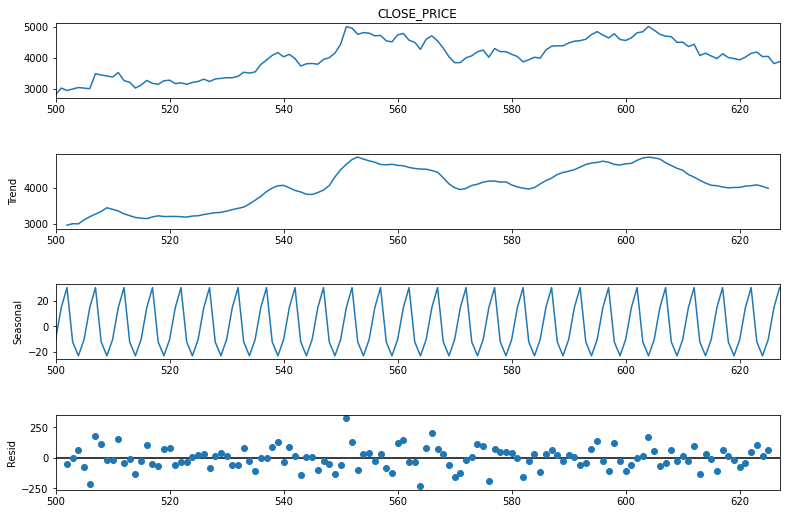

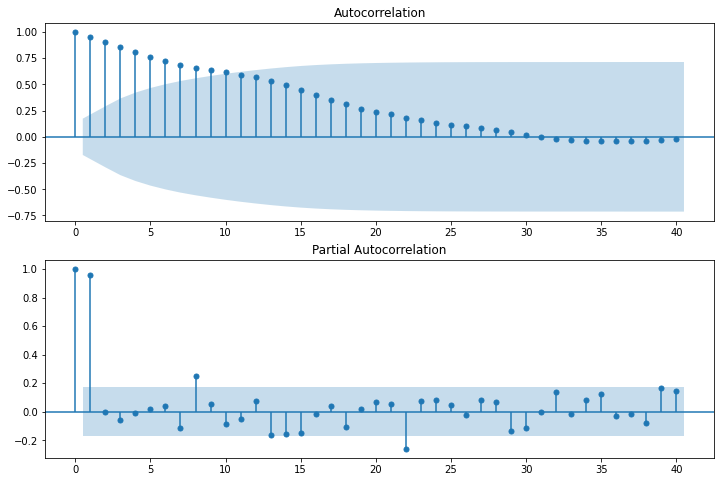

In [110]:
result = seasonal_decompose(df_1[df_1['TICKER']=='OZON']['CLOSE_PRICE'], model='additive', freq = 5)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(12,8)

fig = plt.figure(figsize = (12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_1[df_1['TICKER']=='OZON']['CLOSE_PRICE'], lags = 40, ax =ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_1[df_1['TICKER']=='OZON']['CLOSE_PRICE'], lags = 40, ax = ax2)

<ipython-input-111-ce4cc552fd87>:1: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  result = seasonal_decompose(df_1[df_1['TICKER']=='SBER']['CLOSE_PRICE'], model='additive', freq = 5)


<Figure size 432x288 with 0 Axes>

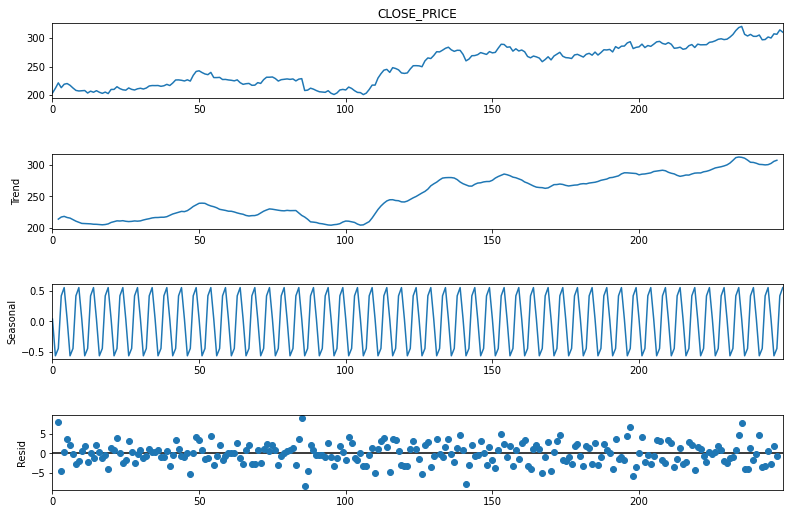

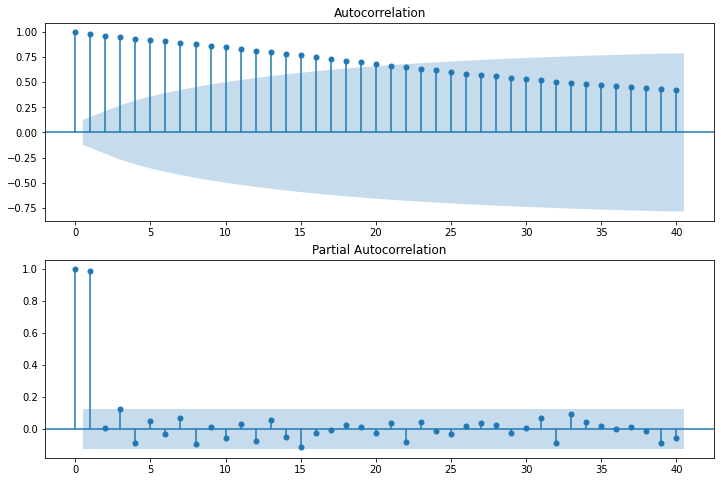

In [111]:
result = seasonal_decompose(df_1[df_1['TICKER']=='SBER']['CLOSE_PRICE'], model='additive', freq = 5)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(12,8)

fig = plt.figure(figsize = (12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_1[df_1['TICKER']=='SBER']['CLOSE_PRICE'], lags = 40, ax =ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_1[df_1['TICKER']=='SBER']['CLOSE_PRICE'], lags = 40, ax = ax2)

<ipython-input-112-f563b03e7638>:1: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  result = seasonal_decompose(df_1[df_1['TICKER']=='YNDX']['CLOSE_PRICE'], model='additive', freq = 5)


<Figure size 432x288 with 0 Axes>

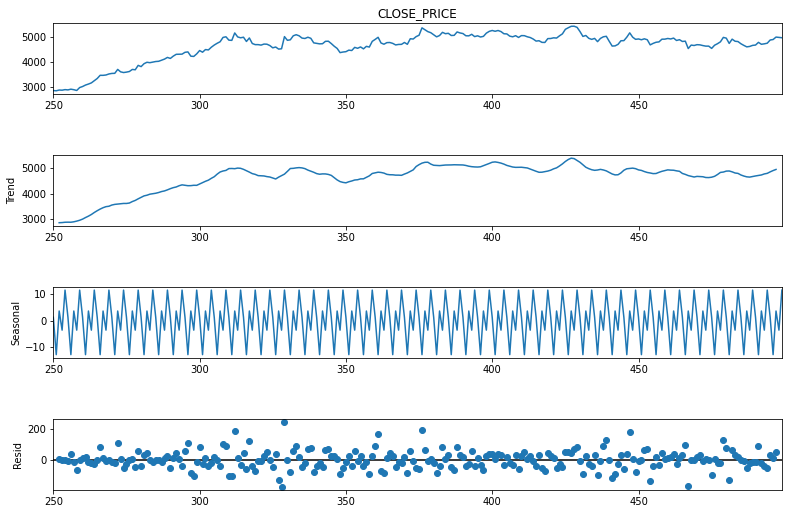

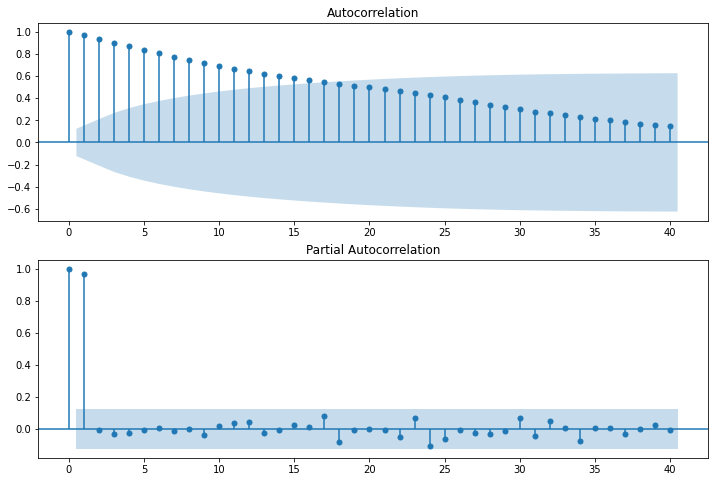

In [112]:
result = seasonal_decompose(df_1[df_1['TICKER']=='YNDX']['CLOSE_PRICE'], model='additive', freq = 5)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(12,8)

fig = plt.figure(figsize = (12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_1[df_1['TICKER']=='YNDX']['CLOSE_PRICE'], lags = 40, ax =ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_1[df_1['TICKER']=='YNDX']['CLOSE_PRICE'], lags = 40, ax = ax2)

In [134]:

stocks_daily_df_4[stocks_daily_df_4['PRICE_DATE'] > '20210521']['TICKER'].nunique()

,index,PRICE_DATE,FIGI,CLOSE_PRICE,OPEN_PRICE,HIGH_PRICE,LOW_PRICE,CURRENCY,NAME,TICKER,ISIN,WEEKDAY,MONTH,SYMBOL,SECTOR,INDUSTRY,MARKET,COUNTRY,LONG_BUSINESS_SUMMARY,CITY,FULL_TIME_EMPLOYEES,TRAILING_ANNUAL_DIVIDEND_YIELD,PAYOUT_RATIO,BETA,PRICE_HINT,FORWARD_PE,ENTERPRISE_TO_EBITDA,FORWARD_EPS,BOOK_VALUE,NET_INCOME_TO_COMMON,ENTERPRISE_TO_REVENUE,PROFIT_MARGINS,PRICE_TO_BOOK,CHANGE_CLOSE_PRICE,CHANGE_OPEN_PRICE,CHANGE_HIGH_PRICE,CHANGE_LOW_PRICE
13404,13528,2021-05-28 07:00:00,BBG000BBV4M5,16.44000,17.38000,17.80000,16.34000,RUB,Центральный Телеграф,CNTL,RU0007665147,4,5,CNTL,Communication Services,Telecom Services,ru_market,Russia,Central Telegraph Public Joint Stock Company p...,Moscow,99.0,0.768182,14.9747,0.234246,2.0,NaN,26.624,NaN,4.430,1.229300e+08,1.619,0.08491,3.525959,0.945915,1.000000,1.024166,0.940161
85645,86429,2021-05-28 07:00:00,BBG000BN56Q9,151.84000,152.50000,153.10000,150.18000,RUB,Детский Мир,DSKY,RU000A0JSQ90,4,5,DSKY,Consumer Cyclical,Department Stores,ru_market,Russia,"Public Joint Stock Company Detsky Mir, a multi...",Moscow,NaN,0.036957,1.1513,0.531578,2.0,14.723196,9.116,10.26,-3.584,6.749000e+09,1.157,0.04723,NaN,0.992289,0.996602,1.000523,0.981440
110266,111240,2021-05-28 07:00:00,BBG000BS4180,0.00535,0.00534,0.00539,0.00525,RUB,Квадра - привилегированные акции,TGKDP,RU000A0JNNB9,4,5,TGKDP,Utilities,Utilities—Regulated Electric,ru_market,Russia,"Public Joint Stock Company ""Quadra - Power Gen...",Tula,12068.0,NaN,0.0000,0.816354,4.0,NaN,5.030,NaN,0.023,3.862500e+07,0.813,0.00070,0.257391,1.019048,1.017143,1.026667,1.000000
136349,137636,2021-05-28 07:00:00,BBG000BX7DH0,67.80000,67.80000,67.80000,67.00000,RUB,ТНС энерго Воронеж,VRSB,RU000A0DPG67,4,5,VRSB,Utilities,Utilities—Regulated Electric,ru_market,Russia,Public Joint-stock Company TNS energo Voronezh...,Voronezh,742.0,0.004179,0.3721,-0.202832,2.0,NaN,26.717,NaN,12.553,2.619900e+08,0.159,0.00986,5.480761,1.002959,1.002959,1.002959,0.991124
158493,159840,2021-05-28 07:00:00,BBG000C7P5M7,0.04590,0.04555,0.04595,0.04555,RUB,МРСК Юга,MRKY,RU000A0JPPG8,4,5,MRKY,Utilities,Utilities—Regulated Electric,ru_market,Russia,"Public Joint Stock Company ""ROSSETI South"" tra...",Rostov-on-Don,NaN,NaN,0.0000,0.685244,4.0,NaN,5.280,NaN,0.019,-1.216389e+09,0.663,-0.02960,2.426316,1.006579,0.998904,1.007675,0.998904
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355867,357895,2021-05-28 07:00:00,BBG00JXPFBN0,2195.50000,2209.00000,2213.00000,2187.50000,RUB,ГДР X5 RetailGroup,FIVE,US98387E2054,4,5,FIVE,Consumer Defensive,Grocery Stores,ru_market,Netherlands,X5 Retail Group N.V. operates as a food retail...,Amsterdam,339716.0,0.077366,1.7699,0.744739,2.0,15.113191,8.066,158.14,377.550,3.198100e+10,0.701,0.01586,6.330287,1.004116,1.010290,1.012120,1.000457
364674,366764,2021-05-28 07:00:00,BBG00QPYJ5H0,5514.80000,5540.00000,5574.00000,5422.20000,RUB,TCS Group,TCSG,TCS7238U2033,4,5,TCSG,Financial Services,Banks—Regional,ru_market,Cyprus,"TCS Group Holding PLC, through its subsidiarie...",Limassol,25970.0,0.010717,0.1912,1.936323,2.0,NaN,NaN,NaN,646.623,4.420900e+10,7.360,0.42302,8.882765,0.986583,0.991091,0.997173,0.970017
367642,369811,2021-05-28 07:00:00,BBG00VPKLPX4,26.57500,26.99000,26.99500,26.25000,RUB,Petropavlovsk PLC,POGR,GB0031544546,4,5,POGR,Basic Materials,Gold,ru_market,United Kingdom,Petropavlovsk PLC operates as a gold mining co...,London,9080.0,NaN,NaN,0.470099,2.0,NaN,268.019,NaN,0.181,-1.724000e+06,96.406,-0.00180,144.254150,0.984077,0.999445,0.999630,0.972042
368346,370555,2021-05-28 07:00:00,BBG00Y91R9T3,3880.00000,3893.50000,3949.00000,3837.00000,RUB,Ozon Holdings PLC,OZON,US69269L1044,4,5,OZON,Consumer Cyclical,Internet Retail,ru_market,Cyprus,"Ozon Holdings PLC, together with its subsidiar...",Nicosia,14834.0,NaN,NaN,NaN,2.0,NaN,-54.493,NaN,389.030,-2.223100e+10,8.028,-0.21336,10.846208,1.017038,1.020577,1.035125,1.005767
